<a href="https://colab.research.google.com/github/rae-fahrenholtz/Elon/blob/main/elon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Elon Musk is one of Silicon Valley's most successful and versatile entrepreneurs. A few of his projects are designing and manufacturing electric cars, building powerful rockets with reusable boosters, and even digging a tunnel deep underground to deal with traffic congestion. And in each case, he started a company. As of February 2022, Musk is the wealthiest person in the world according to both the Bloomberg Billionaires Index and the Forbes real-time billionaires list. Besides being highly successful, Musk has been criticized for his unorthodox and highly publicized controversial statements, primarily through his off-the-cuff social media presence on Twitter. 

In a 2018 interview with '60 Minutes', Musk discussed recent allegations by the US Securities and Exchange Commission (SEC) for falsely tweeting that he had secured funding for a private takeover of Tesla. Musk explained,

"Twitter's a war zone. If somebody's gonna jump in the warzone, it's, like, "Okay, you're in the arena. Let's go!"

Musk's unique social media presence, massive success, and nearly cult following got me thinking...

- Does Elon's presence on Twitter influence the stock price of one of his companies, such as Tesla (TLSA)? 
- Does the amount of public interest in Elon Musk as a person influence the stock price of Tesla (TSLA)?

For my final project with the Thinkful Data Science Certificate Program, I gathered data from various social media sources about what Elon has to say and how interested the general public is in Elon.

# Problem of Interest

Predict Tesla (TSLA) stock price given Technoking of Tesla, aka CEO, Elon Musk social media influence: \\

- Twitter Influence
  - Interest in what Elon has to *SAY*  
    - Measured in average daily tweet likes and average daily number of tweets
- Wiki Searches
    - Interest in *WHO* Elon is as a person
      - Measured in daily number of searches
- Google relative popularity
  - Interest in *WHO* Elon is as a person
    - Measured in daily number of searches
- S&P500 Index
  - Stock Index to capture general trend of the economy 


# Load Data

##Data Sources

### Twitter

Gathered from two sources:

1. [Kaggle](https://www.kaggle.com/ayhmrba/elon-musk-tweets-2010-2021/version/2)
  - Used from Jan 2017 to Mid March 2021 

2. [Twitter API](https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/api-reference/get-users-id-tweets)   
  - Used from Mid March 2021 to Dec 2021
  - Created bash script [elon.sh](https://github.com/rae-fahrenholtz/Elon/blob/main/elon.sh) to run multiple calls to API
  - Requires [Academic Access Level](https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api#v2-access-level) to obtain the full amount of tweets
    - not enough credibility through Thinkful for me to obtain at this time

## Wikipedia
- [Wiki API](https://www.mediawiki.org/wiki/API:Main_page)

## Google
- Pytrends, Unofficial Google Trends API
- [Pytrends Guide](https://lazarinastoy.com/the-ultimate-guide-to-pytrends-google-trends-api-with-python/)

## S&P500 Index
- FRED Python API
- [FRED Python API Guide](https://analyzingalpha.com/get-economic-data-fred-python-api)

In [1]:
#api
!pip install pytrends
!pip install finnhub-python

  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=c6bad6b8ba79164aa242c9d0bff2e7f9975a1a71d513c10508d4bfef5f6f963b
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends


In [2]:
#general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#json
from pandas import json_normalize
import base64
import requests
import json
import urllib

#api
import pandas_datareader.data as web
from pytrends.request import TrendReq
import finnhub

#datetime
import matplotlib.dates as md
import datetime
from datetime import timedelta

#ML
from sklearn.preprocessing import MinMaxScaler

## Twitter Data

Framework:

`tweet_df`: pandas dataframe with all available features from kaggle

`api_tweet_df`: pandas dataframe with all available features from api request

`my_kag_tweet_df`: pandas dataframe with average number of daily likes from Kaggle data source

`my_api_tweet_df`: pandas dataframe with average number of daily likes from Twitter API data source

`my_tweet_df`: pandas data frame of average daily tweet likes and number of daily likes from both data sources

### Kaggle Twitter Data

Data from Kaggle available from two sources:

- Original [Kaggle](https://www.kaggle.com/ayhmrba/elon-musk-tweets-2010-2021/version/2) Data

- csv files saved on Github [repo](https://github.com/rae-fahrenholtz/Elon/tree/main/data) by year in the format `elon_tweets_20xx.csv`


#### `tweet_df`: pandas dataframe with all available features from kaggle

In [3]:
#function to index and clean Elon musk tweet data from github repo

#year: str, no spaces
#possible years: [2017 - 2021]

def get_yearly_elon_tweets(year):
  
  #define url 
  url_a = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/elon_tweets_'
  url_b = year
  url_c = '.csv'
  url = url_a + url_b + url_c

  #read data
  df = pd.read_csv(url, parse_dates=['date'])
  
  #index with date (no hourly)
  df.index = pd.DatetimeIndex(df['date']).floor('D')
  
  #data cleaning
  #only tweets in coresponding year
  start_date = year + '0101' 
  end_date = year + '1231' 
  query_str = start_date + ' <= date <= ' + end_date
  df = df.query(query_str)
  
  #sort index from earliest to newest
  df = df.sort_index()
  
  return(df)

In [4]:
df_2017 = get_yearly_elon_tweets('2017')
df_2018 = get_yearly_elon_tweets('2018')
df_2019 = get_yearly_elon_tweets('2019')
df_2020 = get_yearly_elon_tweets('2020')
df_2021 = get_yearly_elon_tweets('2021')

In [5]:
tweet_df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021], axis=0)

In [6]:
#excludes tweet replies (replies excluded in API data)
tweet_df = tweet_df[tweet_df['reply_to'] == '[]']

In [7]:
tweet_df.shape

(2585, 39)

In [8]:
tweet_df.columns

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'date', 'timezone',
       'place', 'tweet', 'language', 'hashtags', 'cashtags', 'user_id',
       'user_id_str', 'username', 'name', 'day', 'hour', 'link', 'urls',
       'photos', 'video', 'thumbnail', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [9]:
tweet_df.head(3)

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-05,1160,817123579343028227,817123579343028227,1.483652e+12,2017-01-05 21:40:17,0,NaN,Hold-down firing of @SpaceX Falcon 9 at Vanden...,en,[],[],44196397,44196397,elonmusk,Elon Musk,4,21,https://twitter.com/elonmusk/status/8171235793...,[],[],0,NaN,False,14041,469,2873,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2017-01-08,1157,818090148608868353,818090148608868353,1.483883e+12,2017-01-08 13:41:05,0,NaN,New rev for Autopilot HW2 rolling out Mon to f...,en,[],[],44196397,44196397,elonmusk,Elon Musk,7,13,https://twitter.com/elonmusk/status/8180901486...,[],[],0,NaN,False,6092,224,989,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2017-01-08,1156,818090689233711104,818090148608868353,1.483883e+12,2017-01-08 13:43:14,0,NaN,"If all looks good, HW2 Autopilot functionality...",en,[],[],44196397,44196397,elonmusk,Elon Musk,7,13,https://twitter.com/elonmusk/status/8180906892...,[],[],0,NaN,False,2944,139,504,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


`my_kag_tweet_df`: Extracted Twitter features from Kaggle Data

Columns:

`nlikes` = Average daily likes \\
`ntweets` = Number of daily tweets 

In [10]:
my_kag_tweet_df = pd.DataFrame(
    columns=['nlikes', 'ntweets'], 
    index=pd.date_range(start='01-01-2017', end='03-20-21'))

my_kag_tweet_df['nlikes'] = tweet_df['nlikes'].resample('D').mean()
my_kag_tweet_df['ntweets'] = tweet_df['tweet'].groupby(tweet_df.index.date).count()

my_kag_tweet_df = my_kag_tweet_df.fillna(0)  #NaN --> 0

In [11]:
my_kag_tweet_df.shape

(1540, 2)

In [12]:
my_kag_tweet_df.tail(3)

,nlikes,ntweets
2021-03-18,164435.333333,3.0
2021-03-19,327982.000000,1.0
2021-03-20,370258.000000,1.0


### Twitter API Data

- 600 most recent tweets from Elon Musk (excluding replies and retweets) from the [Twitter API](https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/api-reference/get-users-id-tweets)

- json responses saved in [repo](https://www.github.com/rae-fahrenholtz/Elon/data) in 6 files named by most recent tweet date in file

- used to complete 2021 kaggle data 

#### `api_tweet_df`: pandas dataframe with all available features from Twitter API



In [13]:
# function to: json response --> pandas dataframe  
# json data is in repo: https://www.github.com/rae-fahrenholtz/Elon/data

def my_json_to_df(url):
    
  master = url
  req = requests.get(master)
  req = req.text                        #json as string
  d_json = json.loads(req)              #json as dictionary

  likes = []                            #initialize lists
  quotes = []
  replies = []
  retweets = []                           
  dates = []       

  ntweets = len(d_json['data'])         #num of tweets

  #Extract public metrics from json
  for i in range(ntweets):              

      likes.append(d_json['data'][i]
                    ['public_metrics']['like_count'])
      quotes.append(d_json['data'][i]
                    ['public_metrics']['quote_count'])
      replies.append(d_json['data'][i]
                     ['public_metrics']['reply_count'])
      retweets.append(d_json['data'][i]
                      ['public_metrics']['retweet_count'])
      dates.append(d_json['data'][i]['created_at'])

  #dictionary of public metrics
  d_pub_metrics = {'like_count':likes, 'quote_count':quotes, 'reply_count':replies,
            'retweet_count':retweets}
  
  #dataframe of public metrics
  pub_metrics_df = pd.DataFrame(d_pub_metrics, index=pd.to_datetime(dates))

  #Extract id information from json 
  temp_id_df = pd.DataFrame.from_dict(d_json['data'], orient='columns')
  temp_id_df.index = pd.to_datetime(dates)

  id_metrics_df = pd.concat(
    [temp_id_df['text'], temp_id_df['id'], temp_id_df['created_at'], \
     temp_id_df['referenced_tweets']], axis=1)

  #Combine id information with public metrics
  api_tweet_df = pd.concat([id_metrics_df, pub_metrics_df], axis=1)

  return(api_tweet_df)

In [14]:
url1 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2022-01-31'
url2 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-12-01'
url3 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-09-02'
url4 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-06-25'
url5 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-04-15'
url6 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-02-25'

api_tweet1_df = my_json_to_df(url1)
api_tweet2_df = my_json_to_df(url2)
api_tweet3_df = my_json_to_df(url3)
api_tweet4_df = my_json_to_df(url4)
api_tweet5_df = my_json_to_df(url5)
api_tweet6_df = my_json_to_df(url6)

api_tweet_df = pd.concat(
    [api_tweet1_df, api_tweet2_df, api_tweet3_df, api_tweet4_df, \
     api_tweet5_df, api_tweet6_df], axis=0)

api_tweet_df = api_tweet_df.sort_index()  #reorders dates from oldest to newest

#Reindex, dates only 
dates = []

for i in range(api_tweet_df.shape[0]):
  dates.append(api_tweet_df['created_at'][i][0:10])

api_tweet_df.index = pd.to_datetime(dates)

In [15]:
api_tweet_df.shape

(600, 8)

In [16]:
api_tweet_df.head(3)

,text,id,created_at,referenced_tweets,like_count,quote_count,reply_count,retweet_count
2021-01-07,Use Signal,1347165127036977153,2021-01-07T12:56:10.000Z,NaN,351422,12147,15696,43302
2021-01-07,https://t.co/2ja38Z8MRE,1347254119237439495,2021-01-07T18:49:47.000Z,NaN,306031,2736,6784,22896
2021-01-08,"Btw, critical feedback is always super appreci...",1347356316763705344,2021-01-08T01:35:53.000Z,NaN,236880,2711,27128,10337


`my_api_tweet_df`: Extracted Twitter features from Twitter API data

Columns:

`nlikes` = Average daily likes \\
`ntweets` = Number of daily tweets 

In [17]:
my_api_tweet_df = pd.DataFrame(
    columns=['nlikes', 'ntweets'], 
    index=pd.date_range(start='03-21-2021', end='12-31-21'))

my_api_tweet_df['nlikes'] = api_tweet_df['like_count'].resample('D').mean()
my_api_tweet_df['ntweets'] = api_tweet_df['text'].groupby(
    api_tweet_df.index.date).count()
    
my_api_tweet_df = my_api_tweet_df.fillna(0)  #NaN --> 0

In [18]:
my_api_tweet_df.head()

,nlikes,ntweets
2021-03-21,0.0,0.0
2021-03-22,0.0,0.0
2021-03-23,446216.0,1.0
2021-03-24,393710.0,3.0
2021-03-25,394930.0,3.0


In [19]:
my_api_tweet_df.shape

(286, 2)

### Combine Kaggle Tweets and API Tweets

`my_tweet_df`: pandas data frame of average daily tweet likes from both data sources

In [20]:
my_tweet_df = pd.concat([my_kag_tweet_df, my_api_tweet_df], axis = 0)

In [21]:
my_tweet_df.tail(3)

,nlikes,ntweets
2021-12-29,0.0,0.0
2021-12-30,347370.5,2.0
2021-12-31,0.0,0.0


In [22]:
my_tweet_df.shape

(1826, 2)

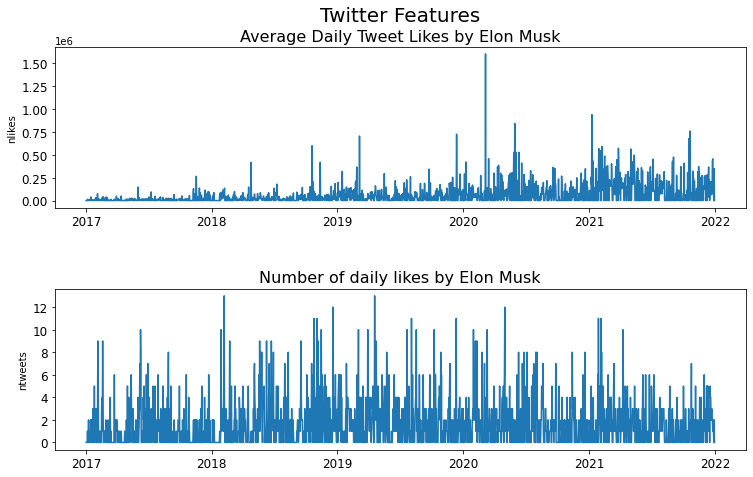

In [23]:
plt.figure(figsize = (12,7))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

plt.suptitle('Twitter Features', size=20)

plt.subplot(2, 1, 1)

ax = sns.lineplot(data=my_tweet_df['nlikes'])  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Average Daily Tweet Likes by Elon Musk', size=16)

plt.subplot(2, 1, 2)

ax = sns.lineplot(data=my_tweet_df['ntweets'])  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Number of daily likes by Elon Musk', size=16)

#plt.savefig('')
#files.download('') 

plt.show()

## Wikipedia Data

In [24]:
url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Elon_Musk/daily/2016010100/2022010100'

uh = urllib.request.urlopen(url)
data = uh.read()
js = json.loads(data.decode("utf-8"))

wiki_df = pd.json_normalize(js, record_path=['items'])

my_wiki_df = pd.DataFrame(wiki_df[['views']])

#removes trailing zeros on timestamp, and pandas format date index
my_wiki_df.index = pd.to_datetime(
    wiki_df['timestamp'].astype(str).str[:-2].astype(np.int64), format='%Y%m%d')

#extract same dates as twitter data
my_wiki_df = my_wiki_df['01-01-2017':'12-31-2021']

#rename column and index
my_wiki_df = my_wiki_df.rename(columns={'views':'wiki'})
my_wiki_df.index = my_wiki_df.index.rename('date')


In [25]:
my_wiki_df.head(3)

,wiki
date,
2017-01-01,19253
2017-01-02,26130
2017-01-03,24114


In [26]:
my_wiki_df.shape

(1826, 1)

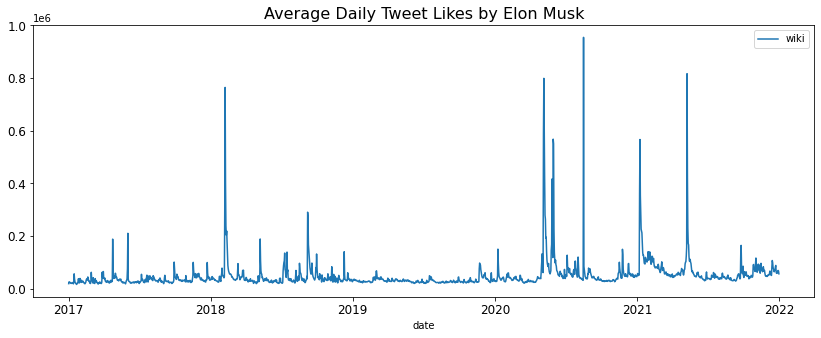

In [27]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_wiki_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Average Daily Tweet Likes by Elon Musk', size=16)

plt.show()

## Google Data

In [28]:
url = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/google_df.csv'
historicaldf = pd.read_csv(url, parse_dates=['date'])
historicaldf.index = historicaldf['date']
historicaldf = historicaldf.drop(['date'], axis=1)

Code used to access google data through pytrends API

```
#build model
pytrend = TrendReq()

#provide your search terms
kw_list = ['Elon Musk']
pytrend.build_payload(kw_list=kw_list)

#historical interest
historicaldf = pytrend.get_historical_interest(kw_list, 
                                                year_start=2017, month_start=1, day_start=1, hour_start=0,
                                                year_end=2021, month_end=12, day_end=31, hour_end=0, 
                                                cat=0, geo='', gprop='', sleep=0)
```
Saved as `google_data.csv` on github to save computational time and minimize issues with bot security measures for pytrends


In [29]:
#daily average popularity 
daily_series = historicaldf['Elon Musk'].resample('D').mean()

#Fill missing values with linear interpolation
daily_series = daily_series.fillna(daily_series.interpolate())

#pandas series --> pandas dataframe
my_google_df = pd.DataFrame(daily_series)

#rename column from 'Elon Musk' to 'google'
my_google_df = my_google_df.rename(columns={"Elon Musk": "google"})

In [30]:
my_google_df.head()

,google
date,
2017-01-01,49.208333
2017-01-02,51.250000
2017-01-03,50.833333
2017-01-04,53.583333
2017-01-05,52.625000


In [31]:
my_google_df.shape

(1826, 1)

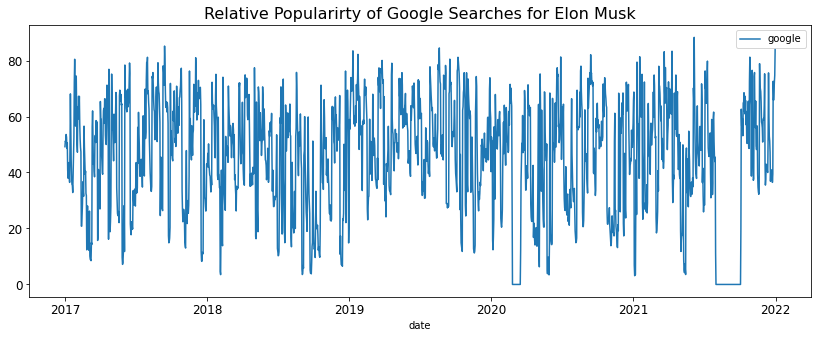

In [32]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_google_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Relative Popularirty of Google Searches for Elon Musk', size=16)

plt.show()

## S&P500 Index Data

In [33]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2021, 12, 31)

my_sp_df = web.DataReader(['sp500'], 'fred', start_date, end_date)

#rename index 
my_sp_df.index = my_sp_df.index.rename('date')

#reindex for all dates in each year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

#for days with no quotes, fill with missing value, (np.NaN is default)
my_sp_df = my_sp_df.reindex(all_dates)

#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections
my_sp_df['sp500'] = my_sp_df['sp500'].fillna(my_sp_df['sp500'].interpolate(limit_direction='both'))

In [34]:
my_sp_df.head()

,sp500
2017-01-01,2257.83
2017-01-02,2257.83
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00


In [35]:
my_sp_df.shape

(1826, 1)

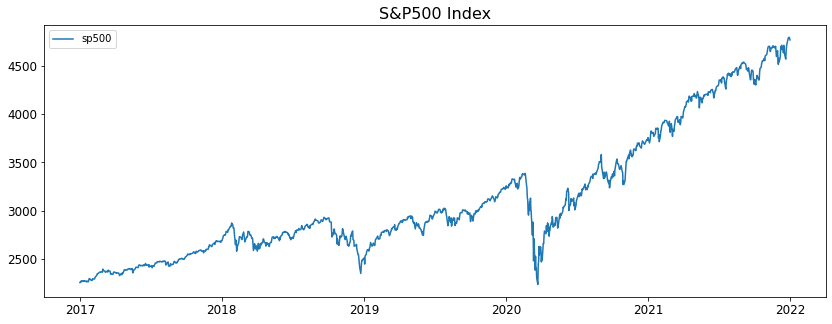

In [36]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_sp_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('S&P500 Index', size=16)

plt.show()

## TSLA Data

In [37]:
finnhub_client = finnhub.Client(api_key="c7h1h52ad3ibsjtt5ug0")

In [38]:
epoch_start_date = 1483228800
epoch_end_date = 1640908800

In [39]:
#display the high, low, open, and closing prices of a security for a specific 
#period in epoch time (1/1/2017 - 12/31/2021)
tsla_candle_df = pd.DataFrame(finnhub_client.stock_candles(
    'TSLA', 'D', epoch_start_date, epoch_end_date))

#create time column and index in YYYY-MM-DD format
tsla_candle_df['date'] = pd.to_datetime(tsla_candle_df['t'],unit='s')
tsla_candle_df = tsla_candle_df.set_index('date')

# extract closing column ('c') with same index
my_tsla_df = pd.DataFrame(tsla_candle_df['c'], index=tsla_candle_df.index)
my_tsla_df = my_tsla_df.rename(columns={'c': 'tsla'})

In [40]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

#for days with no quotes, fill with missing value, (np.NaN is default)
my_tsla_df = my_tsla_df.reindex(all_dates)

#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections
my_tsla_df['tsla'] = my_tsla_df['tsla'].fillna(my_tsla_df['tsla'].interpolate(limit_direction='both'))

In [41]:
my_tsla_df.head()

,tsla
2017-01-01,43.398
2017-01-02,43.398
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350


In [42]:
my_tsla_df.shape

(1826, 1)

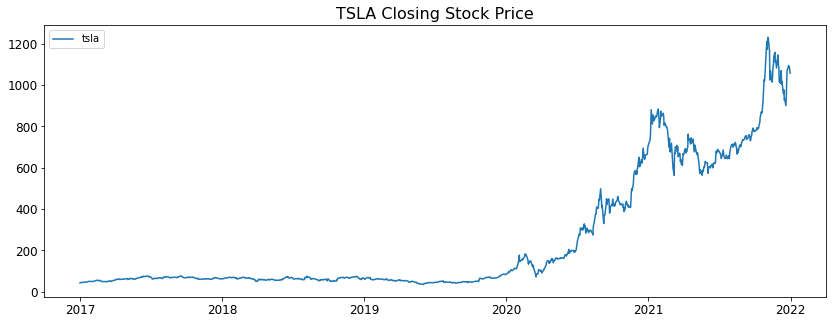

In [43]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_tsla_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('TSLA Closing Stock Price', size=16)

plt.show()

## Combine data into one dataframe

In [44]:
elon_df = pd.concat(
    [my_tsla_df, my_tweet_df, my_wiki_df, my_google_df, my_sp_df], axis=1)

In [45]:
elon_df.head()

,tsla,nlikes,ntweets,wiki,google,sp500
2017-01-01,43.398,0.0,0.0,19253,49.208333,2257.83
2017-01-02,43.398,0.0,0.0,26130,51.250000,2257.83
2017-01-03,43.398,0.0,0.0,24114,50.833333,2257.83
2017-01-04,45.398,0.0,0.0,24535,53.583333,2270.75
2017-01-05,45.350,14041.0,1.0,23229,52.625000,2269.00


## Create other variables

In [46]:
#first difference
elon_df['tsla_diff'] = elon_df['tsla'].diff()
elon_df['nlikes_diff'] = elon_df['nlikes'].diff()
elon_df['ntweets_diff'] = elon_df['ntweets'].diff()
elon_df['wiki_diff'] = elon_df['wiki'].diff()
elon_df['google_diff'] = elon_df['google'].diff()
elon_df['sp500_diff'] = elon_df['sp500'].diff()

#3 day rolling average
rolling3_df = pd.DataFrame(
    elon_df.loc[:,['tsla', 'nlikes', 'ntweets', 'wiki', 'google', 'sp500']
                ].rolling(3).mean())
rolling3_df = rolling3_df.rename(
    columns={'tsla':'tsla_3', 'nlikes':'nlikes_3', 'ntweets':'ntweets_3', 
             'wiki':'wiki_3', 'google':'google_3', 'sp500':'sp500_3'})

elon_df = pd.concat([elon_df, rolling3_df], axis=1)

#7 day rolling average
rolling7_df = pd.DataFrame(
    elon_df.loc[:,['tsla', 'nlikes', 'ntweets', 'wiki', 'google', 'sp500']
                ].rolling(7).mean())
rolling7_df = rolling7_df.rename(
    columns={'tsla':'tsla_7', 'nlikes':'nlikes_7', 'ntweets':'ntweets_7', 
             'wiki':'wiki_7', 'google':'google_7', 'sp500':'sp500_7'})

elon_df = pd.concat([elon_df, rolling7_df], axis=1)

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
cols_to_standardize_df = elon_df.loc[:,['tsla', 'nlikes', 'ntweets', 'wiki', 
                                        'google', 'sp500', 'tsla_diff', 
                                        'nlikes_diff', 'ntweets_diff', 
                                        'wiki_diff', 'google_diff', 
                                        'sp500_diff','tsla_3', 'nlikes_3', 
                                        'ntweets_3', 'wiki_3', 'google_3', 
                                        'tsla_7', 'nlikes_7', 'ntweets_7', 
                                        'wiki_7', 'google_7']]

In [49]:
scaler = MinMaxScaler()
elon_std_df = pd.DataFrame(
    scaler.fit_transform(cols_to_standardize_df), 
    columns=cols_to_standardize_df.columns)

# Analysis

## Vector Autoregression (VAR)

I was familiar with modeling univariate time dependent data using ARIMA (autoregressive integrated moving average) modeling techniques from my statistics background. So, for this *multivariate* time series problem, I used Vector autoregression, another type of stochastic process model used to capture the relationship between *multiple quantities* as they change over time.

In [50]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [51]:
elon_df.head(3)

,tsla,nlikes,ntweets,wiki,google,sp500,tsla_diff,nlikes_diff,ntweets_diff,wiki_diff,google_diff,sp500_diff,tsla_3,nlikes_3,ntweets_3,wiki_3,google_3,sp500_3,tsla_7,nlikes_7,ntweets_7,wiki_7,google_7,sp500_7
2017-01-01,43.398,0.0,0.0,19253,49.208333,2257.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,43.398,0.0,0.0,26130,51.250000,2257.83,0.0,0.0,0.0,6877.0,2.041667,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,43.398,0.0,0.0,24114,50.833333,2257.83,0.0,0.0,0.0,-2016.0,-0.416667,0.0,43.398,0.0,0.0,23165.666667,50.430556,2257.83,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
elon_df.shape

(1826, 24)

In [53]:
df = elon_df.loc[:,['tsla', 'nlikes', 'ntweets', 'google', 'wiki', 'sp500']]

In [54]:
# split into test and train
n_test = 20
df_train, df_test = df.iloc[:-n_test], df.iloc[-n_test:]

### Test for stationarity

For Vector Autoregression, we need each variable to be stationary. We will use the statistical test, Augemented Dickey-Fuller Test (ADF Test) to check for stationarity. 

In [55]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [56]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "tsla" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.485
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.9844. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "nlikes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5278
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0073. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ntweets" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

`tsla` and `sp500` fail to reject the null hypothesis. There is strong evidence that these two variables are non-stationary. We will consider the first difference for each variable and test for stationarity on these transformed variables. 

In [57]:
#preserve date index (includes NA)
df_1d = elon_df.loc[:,['tsla_diff', 'nlikes_diff', 'ntweets_diff', 
                        'google_diff', 'wiki_diff', 'sp500_diff']]
#for modeling (excludes NA)                       
df_diff = df_1d.dropna()                        

In [58]:
# split into test and train
n_test = 20
df_diff_train = df_diff.iloc[:(len(df_diff)-n_test)]
df_diff_test = df_diff.iloc[(len(df_diff)-n_test):]

In [59]:
for name, column in df_diff_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "tsla_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1612
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "nlikes_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.7187
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ntweets_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signif

The first difference of each variable all reject the null hypothesis. There is strong evidence that the first difference of the variables are stationary. Hoorah!

### Modeling

In [60]:
model = VAR(df_diff_train)
select_p = model.select_order(maxlags=12)
select_p.summary()

,AIC,BIC,FPE,HQIC
0,63.49,63.50,3.726e+27,63.49
1,62.93,63.06,2.147e+27,62.98
2,62.61,62.85,1.558e+27,62.70
3,62.41,62.76*,1.271e+27,62.54
4,62.37,62.83,1.216e+27,62.54
5,62.29,62.86,1.129e+27,62.50
6,62.24,62.92,1.074e+27,62.49
7,62.19,62.98,1.017e+27,62.48*
8,62.16,63.06,9.919e+26,62.49
9,62.15,63.16,9.802e+26,62.52


Model Selection Criteria: 
```
AIC: lag = 12 (max)
BIC: lag = 3
FPE: lag = 12 (max)
HQUC: lag = 7
```
I will begin with the simpliest model and use a lag of 3. 

In [61]:
model_fitted = model.fit(3)
lag_order = model_fitted.k_ar

### Forecasting

In [62]:
forecast_input = df_diff_train.values[-lag_order:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_test)
df_diff_forecast = pd.DataFrame(forecast, columns=df_test.columns, 
                           index=df_diff_test.index)

In [63]:
def forecast_plots(series_name):
  #series_name; str
  plt.plot(df_diff_test[series_name+'_diff'])
  plt.plot(df_diff_forecast[series_name])
  plt.legend(['actual','predict'])
  plt.xticks(color='w')
  plt.title(series_name+' diff')

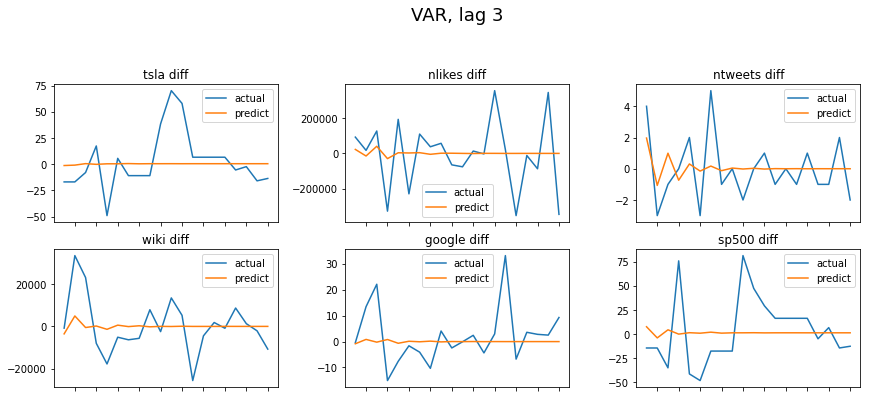

In [64]:
plt.figure(figsize = (14,6))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.2)

plt.suptitle('VAR, lag 3', size=18)

plt.subplot(2, 3, 1)
forecast_plots('tsla')

plt.subplot(2, 3, 2)
forecast_plots('nlikes')

plt.subplot(2, 3, 3)
forecast_plots('ntweets')

plt.subplot(2, 3, 4)
forecast_plots('wiki')

plt.subplot(2, 3, 5)
forecast_plots('google')

plt.subplot(2, 3, 6)
forecast_plots('sp500')

#plt.savefig('')
#files.download('') 

plt.show()

The first difference for `tsla` is predicted to be approximately zero; today's price is the best estimate for tomorrow's price. Not so horrah.

Transform back to original scales

In [65]:
cols = df_diff_forecast.columns

df_fc = pd.DataFrame(columns=df_test.columns, index=df_test.index)

for col in cols:
  for i in range(1, len(df_diff_test)):    
    df_fc[col][i] = df_diff_forecast[col][i] + df_test[col][i-1]

df_fc = df.rename(columns={
    'tsla':'tsla_forecast', 
    'nlikes':'nlikes_forecast',
    'ntweets':'ntweets_forecast',
    'google':'google_forecast',
    'wiki':'wiki_forecast',
    'sp500':'sp500_forecast'})

In [66]:
pred_actual_df = pd.concat([df_test, df_fc], axis=1)

In [69]:
def forecast_plots2(series_name):
  #series_name; str
  plt.plot(pred_actual_df[series_name], alpha=.5)
  plt.plot(pred_actual_df[series_name+'_forecast'])
  plt.legend(['actual','predict'])
  plt.xticks(color='w')
  plt.title(series_name)

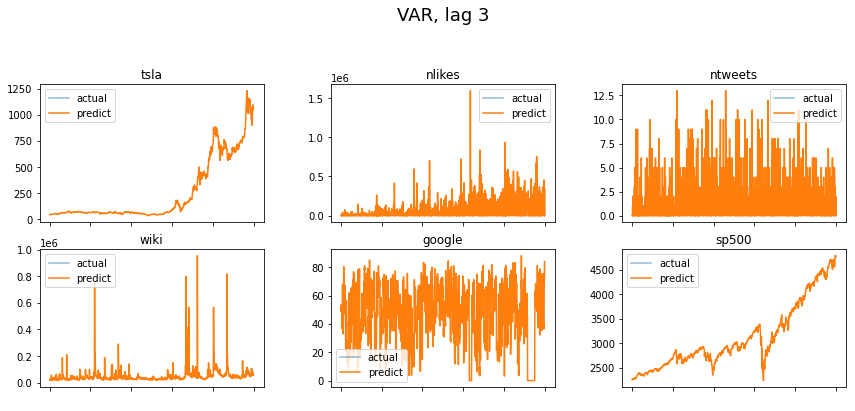

In [70]:
plt.figure(figsize = (14,6))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.2)

plt.suptitle('VAR, lag 3', size=18)

plt.subplot(2, 3, 1)
forecast_plots2('tsla')

plt.subplot(2, 3, 2)
forecast_plots2('nlikes')

plt.subplot(2, 3, 3)
forecast_plots2('ntweets')

plt.subplot(2, 3, 4)
forecast_plots2('wiki')

plt.subplot(2, 3, 5)
forecast_plots2('google')

plt.subplot(2, 3, 6)
forecast_plots2('sp500')

#plt.savefig('')
#files.download('') 

plt.show()

It is difficult to distinguish between the actual and prediction in the plots above because they are plotted on top of each other. This is because, for each varaible, the daily change between today and tomorrow is predicted to be about zero; Best 'guess' for tomorrow's value is today.

I explored increasing the lag for the VAR model, but witnessed no significant improvment in model performance.

Intuitively, from our exploratory data analysis (EDA) notebook, `eda.ipynb`, in the section `Time-lagged Cross Correlation`, we found no apparent relationship between the Pearson's correlation and lag for our featurs and target. The correlation stayed relatively constant for all lags. So, perhaps a model based on lags is not the best choice. To machine learning we go!

##LSTM

Next, I wanted to explore modeling using Long Short-Term Memory (LSTM) modeling. This is a prefered modeling technique for multivarate time series because it addresses the issue that after a while, RNNs (recurrent neural networks), will contain virutally no trace of first inputs. To tackle this problem, researchers proposed using the Long Short-Term Memory cell.

For this section in LSTM modeling, I will explore using three unique feature sets: 

1. Full feature set 
  - `nlikes`, `ntweets`, `wiki`, `google`, and `sp500`
2. Full feature set at time, t-1, *and* target at t-1
  - Inspired by this analysis: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

3. One Feature, `sp500`  

For each Feature set, I will first explore two models:

1. Simple LSTM
2. LSTM with more layers

To evalulate these models, I will use two error metrics on forecasts on the validation set: 

- RMSE (unbiased)
- MAE (less sensitive to outliers)

Fianally, we will finsih with an implementation of a sliding window with LSTM for each of the three feature sets.

In [ ]:
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

### Data Preparation for Modeling

In [ ]:
#function for custom reshape of input to be 3D [samples, timesteps, features]
#for Walking forwarding validation with window
#used with "LSTM with more layers"

def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
      end = len(dataset) - horizon
  for i in range(start, end):
      indices = range(i-window, i)
      X.append(dataset[indices])
      indicey = range(i+1, i+1+horizon)
      y.append(target[indicey])
  return np.array(X), np.array(y)

In [ ]:
#function to prepare data for ML with Feature Set 2

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#### For Feature Set 1

In [ ]:
df = elon_df[['tsla',	'nlikes',	'ntweets', 'wiki',	'google',	'sp500']]

In [ ]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_data = X_scaler.fit_transform(
    df[['nlikes',	'ntweets', 'wiki', 'google', 'sp500']])
Y_data = Y_scaler.fit_transform(df['tsla'].values.reshape(-1,1))

In [ ]:
#train and validation set for simple LSTM
train_X, train_y = X_data[:1200, :], Y_data[:1200]
valid_X, valid_y = X_data[1200:,:], Y_data[1200:]

In [ ]:
print("Percent Training Set: {:.1f}%".format(len(train_X) / len(Y_data)*100))

Percent Training Set: 65.7%


In [ ]:
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(1200, 1, 5) (1200, 1) (626, 1, 5) (626, 1)


In [ ]:
hist_window = 1
horizon = 1        #how many days ahead to predict
TRAIN_SPLIT = 1201 #total obs to use

#train and validation set for LSTM with more layers
x_trai, y_trai = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print(x_trai.shape, y_trai.shape, x_vali.shape, y_vali.shape)

(1200, 1, 5) (1200, 1, 1) (623, 1, 5) (623, 1, 1)


#### For Feature Set 2

In [ ]:
df = elon_df[['tsla',	'nlikes',	'ntweets', 'wiki',	'google',	'sp500']]

X_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(
    df[['tsla', 'nlikes',	'ntweets', 'wiki', 'google', 'sp500']])

In [ ]:
reframedX = series_to_supervised(X_data, 1, 1).drop(
    columns=['var2(t)','var3(t)','var4(t)','var5(t)', 'var6(t)'])
reframedX.tail(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1821,0.880493,0.284287,0.076923,0.046849,0.822383,0.992871,0.886133
1822,0.886133,0.062248,0.153846,0.045924,0.745733,0.999268,0.881553
1823,0.881553,0.054852,0.076923,0.055222,0.786324,0.997374,0.879643
1824,0.879643,0.000000,0.000000,0.056607,0.817947,1.000000,0.866370
1825,0.866370,0.217579,0.153846,0.054387,0.846266,0.994393,0.855014


In [ ]:
X_data2 = np.array(reframedX.iloc[:,:-1])
Y_data2 = np.array(reframedX.iloc[:,-1])

In [ ]:
#train and validation set for simple LSTM
train2_X, train2_y = X_data2[:1200, :], Y_data2[:1200]
valid2_X, valid2_y = X_data2[1200:,:], Y_data2[1200:]

In [ ]:
print("Percent Training Set: {:.1f}%".format(len(train2_X) / len(Y_data2)*100))

Percent Training Set: 65.8%


In [ ]:
#reshape input to be 3D [samples, timesteps, features]
train2_X = train2_X.reshape((train2_X.shape[0], 1, train2_X.shape[1]))
valid2_X = valid2_X.reshape((valid2_X.shape[0], 1, valid2_X.shape[1]))
print(train2_X.shape, train2_y.shape, valid2_X.shape, valid2_y.shape)

(1200, 1, 6) (1200,) (625, 1, 6) (625,)


In [ ]:
hist_window = 1
horizon = 1        #how many days ahead to predict
TRAIN_SPLIT = 1201 #total obs to use

#train and validation set for LSTM with more layers
x_trai2, y_trai2 = custom_ts_multi_data_prep(X_data2, Y_data2, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali2, y_vali2 = custom_ts_multi_data_prep(X_data2, Y_data2, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print(x_trai2.shape, y_trai2.shape, x_vali2.shape, y_vali2.shape)

(1200, 1, 6) (1200, 1) (622, 1, 6) (622, 1)


#### For Feature Set 3

In [ ]:
df = elon_df[['tsla',	'sp500']]

In [ ]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_data3 = X_scaler.fit_transform(
    df[['sp500']])
Y_data3 = Y_scaler.fit_transform(df['tsla'].values.reshape(-1,1))

In [ ]:
#train and validation set for simple LSTM
train3_X, train3_y = X_data3[:1200, :], Y_data3[:1200]
valid3_X, valid3_y = X_data3[1200:,:], Y_data3[1200:]

In [ ]:
print("Percent Training Set: {:.1f}%".format(len(train3_X) / len(Y_data3)*100))

Percent Training Set: 65.7%


In [ ]:
#reshape input to be 3D [samples, timesteps, features]
train3_X = train3_X.reshape((train3_X.shape[0], 1, train3_X.shape[1]))
valid3_X = valid3_X.reshape((valid3_X.shape[0], 1, valid3_X.shape[1]))
print(train3_X.shape, train3_y.shape, valid3_X.shape, valid3_y.shape)

(1200, 1, 1) (1200, 1) (626, 1, 1) (626, 1)


In [ ]:
hist_window = 1
horizon = 1        #how many days ahead to predict
TRAIN_SPLIT = 1201 #total obs to use

#train and validation set for LSTM with more layers
x_trai3, y_trai3 = custom_ts_multi_data_prep(X_data3, Y_data3, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali3, y_vali3 = custom_ts_multi_data_prep(X_data3, Y_data3, TRAIN_SPLIT, None, hist_window, horizon)

### Modeling

#### Initial LSTM Modeling

##### Feature Set 1

###### Simple LSTM

In [ ]:
#build and compile LSTM model
model1 = Sequential()
model1.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mse', optimizer='adam')

In [ ]:
#fit model
history = model1.fit(train_X, train_y, epochs=80,
                     batch_size=100, 
                     validation_data=(valid_X, valid_y), verbose=1, 
                     shuffle=False)

Epoch 1/80
12/12 [==============================] - 5s 122ms/step - loss: 5.9520e-04 - val_loss: 0.2652
Epoch 2/80
12/12 [==============================] - 0s 27ms/step - loss: 3.7812e-04 - val_loss: 0.2448
Epoch 3/80
12/12 [==============================] - 0s 25ms/step - loss: 3.7195e-04 - val_loss: 0.2472
Epoch 4/80
12/12 [==============================] - 0s 22ms/step - loss: 3.2947e-04 - val_loss: 0.2394
Epoch 5/80
12/12 [==============================] - 0s 25ms/step - loss: 3.3339e-04 - val_loss: 0.2378
Epoch 6/80
12/12 [==============================] - 0s 26ms/step - loss: 3.2501e-04 - val_loss: 0.2349
Epoch 7/80
12/12 [==============================] - 0s 27ms/step - loss: 3.2817e-04 - val_loss: 0.2335
Epoch 8/80
12/12 [==============================] - 0s 21ms/step - loss: 3.2603e-04 - val_loss: 0.2323
Epoch 9/80
12/12 [==============================] - 0s 24ms/step - loss: 3.2739e-04 - val_loss: 0.2315
Epoch 10/80
12/12 [==============================] - 0s 26ms/step - loss

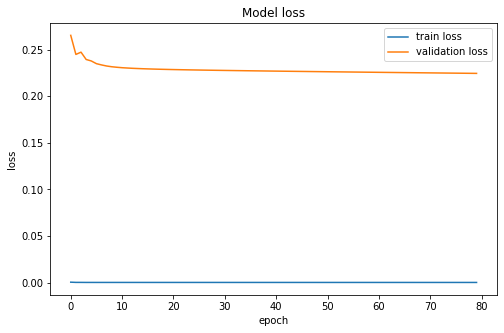

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#prediction
model1_yhat = model1.predict(valid_X)

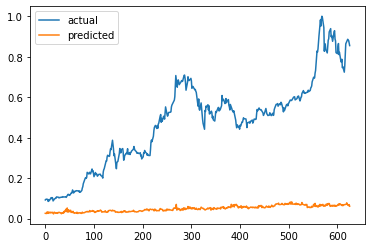

In [ ]:
plt.plot(valid_y)
plt.plot(model1_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model1_rmse = sqrt(mean_squared_error(valid_y, model1_yhat))
print('RMSE: {:.4f}'.format(model1_rmse))

model1_mae = mean_absolute_error(valid_y, model1_yhat)
print('MAE: {:.4f}'.format(model1_mae))

RMSE: 0.4738
MAE: 0.4254


###### LSTM with more layers

In [ ]:
#prepare data 
batch_size = 100
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_trai, y_trai))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat() 

In [ ]:
#Build and compile the model

model2 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                              input_shape=x_trai.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

model2.compile(optimizer='adam', loss='mse')

In [ ]:
history = model2.fit(train_data, epochs=80, steps_per_epoch=10,
                         validation_data=val_data, validation_steps=3,
                         verbose=1, shuffle=False
                         )

Epoch 1/80
10/10 [==============================] - 9s 214ms/step - loss: 1.2242e-04 - val_loss: 0.1275
Epoch 2/80
10/10 [==============================] - 0s 16ms/step - loss: 5.1484e-04 - val_loss: 0.1264
Epoch 3/80
10/10 [==============================] - 0s 16ms/step - loss: 6.6384e-04 - val_loss: 0.1138
Epoch 4/80
10/10 [==============================] - 0s 14ms/step - loss: 5.5036e-04 - val_loss: 0.1243
Epoch 5/80
10/10 [==============================] - 0s 15ms/step - loss: 4.1957e-04 - val_loss: 0.1207
Epoch 6/80
10/10 [==============================] - 0s 15ms/step - loss: 4.7371e-04 - val_loss: 0.1250
Epoch 7/80
10/10 [==============================] - 0s 14ms/step - loss: 1.1057e-04 - val_loss: 0.1221
Epoch 8/80
10/10 [==============================] - 0s 14ms/step - loss: 3.7815e-04 - val_loss: 0.1193
Epoch 9/80
10/10 [==============================] - 0s 15ms/step - loss: 4.3662e-04 - val_loss: 0.1169
Epoch 10/80
10/10 [==============================] - 0s 17ms/step - loss

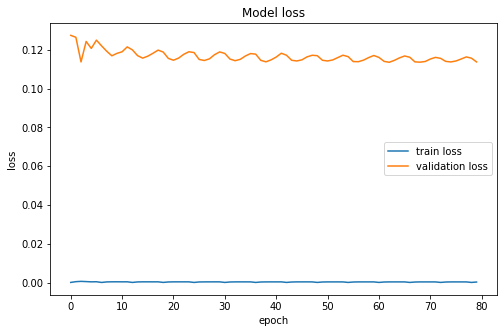

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#predictions
model2_yhat = model2.predict(x_vali)

In [ ]:
#reshape for plot and rmse
y_vali = y_vali.reshape(y_vali.shape[0])
model2_yhat = model2_yhat.reshape(model2_yhat.shape[0])

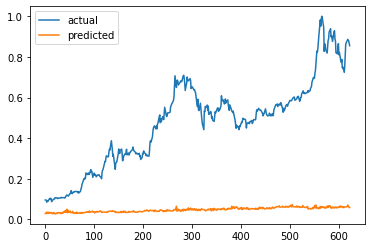

In [ ]:
plt.plot(y_vali)
plt.plot(model2_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model2_rmse = sqrt(mean_squared_error(y_vali, model2_yhat))
print('RMSE: {:.4f}'.format(model2_rmse))

model2_mae = mean_absolute_error(y_vali, model2_yhat)
print('MAE: {:.4f}'.format(model2_mae))

RMSE: 0.4780
MAE: 0.4293


Simplicity wins! 

##### Feature Set 2

###### Simple LSTM 

train/validation set for Feature set 2: `train2_X`, `train2_y`, `valid2_X`, `valid2_y`

In [ ]:
#build and compile LSTM model
model3 = Sequential()
model3.add(LSTM(200, input_shape=(train2_X.shape[1], train2_X.shape[2])))
model3.add(Dense(1))
model3.compile(loss='mse', optimizer='adam')

In [ ]:
#fit model
history = model3.fit(train2_X, train2_y, epochs=80,
                     batch_size=100, 
                     validation_data=(valid2_X, valid2_y), 
                     verbose=1, shuffle=False)

Epoch 1/80
12/12 [==============================] - 2s 59ms/step - loss: 6.1012e-04 - val_loss: 0.2696
Epoch 2/80
12/12 [==============================] - 0s 11ms/step - loss: 3.6069e-04 - val_loss: 0.2503
Epoch 3/80
12/12 [==============================] - 0s 11ms/step - loss: 3.6152e-04 - val_loss: 0.2410
Epoch 4/80
12/12 [==============================] - 0s 11ms/step - loss: 3.1687e-04 - val_loss: 0.2294
Epoch 5/80
12/12 [==============================] - 0s 10ms/step - loss: 3.1314e-04 - val_loss: 0.2197
Epoch 6/80
12/12 [==============================] - 0s 11ms/step - loss: 2.9760e-04 - val_loss: 0.2113
Epoch 7/80
12/12 [==============================] - 0s 11ms/step - loss: 2.9214e-04 - val_loss: 0.2033
Epoch 8/80
12/12 [==============================] - 0s 12ms/step - loss: 2.8276e-04 - val_loss: 0.1963
Epoch 9/80
12/12 [==============================] - 0s 10ms/step - loss: 2.7614e-04 - val_loss: 0.1895
Epoch 10/80
12/12 [==============================] - 0s 11ms/step - loss:

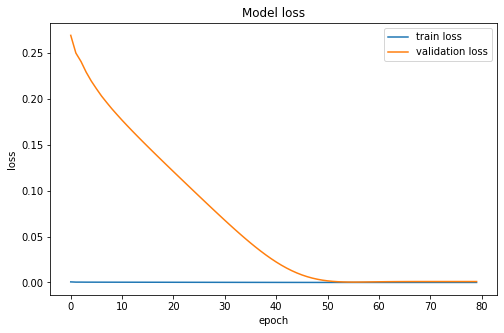

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#prediction
model3_yhat = model3.predict(valid2_X)

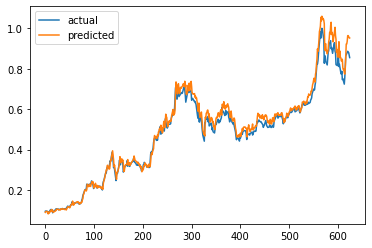

In [ ]:
plt.plot(valid2_y)
plt.plot(model3_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model3_rmse = sqrt(mean_squared_error(valid2_y, model3_yhat))
print('RMSE: {:.4f}'.format(model3_rmse))

model3_mae = mean_absolute_error(valid2_y, model3_yhat)
print('MAE: {:.4f}'.format(model3_mae))

RMSE: 0.0317
MAE: 0.0220


###### LSTM with more layers 

train/validation set for Feature set 2: `x_trai2`, `y_trai2`, `x_vali2`, `y_vali2`

In [ ]:
#prepare data 
batch_size = 100
buffer_size = 50
train2_data = tf.data.Dataset.from_tensor_slices((x_trai2, y_trai2))
train2_data = train2_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val2_data = tf.data.Dataset.from_tensor_slices((x_vali2, y_vali2))
val2_data = val2_data.batch(batch_size).repeat()

In [ ]:
#Build and compile the model

model4 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                              input_shape=x_trai2.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

model4.compile(optimizer='adam', loss='mse')

In [ ]:
history = model4.fit(train2_data, epochs=80, steps_per_epoch=10,
                         validation_data=val2_data, validation_steps=3,
                         verbose=1, shuffle=False
                         )

Epoch 1/80
10/10 [==============================] - 13s 217ms/step - loss: 1.1562e-04 - val_loss: 0.1298
Epoch 2/80
10/10 [==============================] - 0s 15ms/step - loss: 5.3707e-04 - val_loss: 0.1269
Epoch 3/80
10/10 [==============================] - 0s 15ms/step - loss: 6.5462e-04 - val_loss: 0.1143
Epoch 4/80
10/10 [==============================] - 0s 14ms/step - loss: 5.3374e-04 - val_loss: 0.1249
Epoch 5/80
10/10 [==============================] - 0s 15ms/step - loss: 4.3045e-04 - val_loss: 0.1212
Epoch 6/80
10/10 [==============================] - 0s 15ms/step - loss: 4.5982e-04 - val_loss: 0.1239
Epoch 7/80
10/10 [==============================] - 0s 18ms/step - loss: 1.0283e-04 - val_loss: 0.1218
Epoch 8/80
10/10 [==============================] - 0s 16ms/step - loss: 3.8058e-04 - val_loss: 0.1178
Epoch 9/80
10/10 [==============================] - 0s 16ms/step - loss: 4.3767e-04 - val_loss: 0.1149
Epoch 10/80
10/10 [==============================] - 0s 18ms/step - los

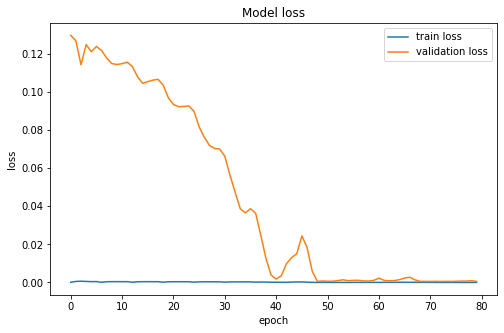

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#predictions
model4_yhat = model4.predict(x_vali2)

In [ ]:
#reshape for plot and rmse
y_vali2 = y_vali2.reshape(y_vali2.shape[0])
model4_yhat = model4_yhat.reshape(model4_yhat.shape[0])

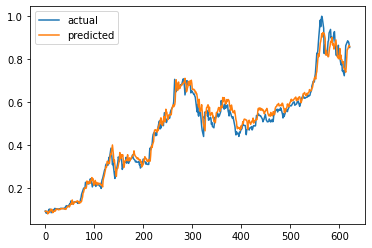

In [ ]:
plt.plot(y_vali2)
plt.plot(model4_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model4_rmse = sqrt(mean_squared_error(y_vali2, model4_yhat))
print('RMSE: {:.4f}'.format(model4_rmse))

model4_mae = mean_absolute_error(y_vali2, model4_yhat)
print('MAE: {:.4f}'.format(model4_mae))

RMSE: 0.0325
MAE: 0.0241


Simplicity wins! 

##### Feature Set 3

###### Simple LSTM 

train/validation set for Feature set 3: `train3_X`, `train3_y`, `valid3_X`, `valid3_y`

In [ ]:
#build and compile LSTM model
model5 = Sequential()
model5.add(LSTM(200, input_shape=(train3_X.shape[1], train3_X.shape[2])))
model5.add(Dense(1))
model5.compile(loss='mse', optimizer='adam')

In [ ]:
#fit model
history = model5.fit(train3_X, train3_y, epochs=80,
                     batch_size=100, 
                     validation_data=(valid3_X, valid3_y), 
                     verbose=1, shuffle=False)

Epoch 1/80
12/12 [==============================] - 2s 57ms/step - loss: 4.4345e-04 - val_loss: 0.2420
Epoch 2/80
12/12 [==============================] - 0s 10ms/step - loss: 3.2625e-04 - val_loss: 0.2428
Epoch 3/80
12/12 [==============================] - 0s 12ms/step - loss: 3.2030e-04 - val_loss: 0.2384
Epoch 4/80
12/12 [==============================] - 0s 12ms/step - loss: 3.2134e-04 - val_loss: 0.2377
Epoch 5/80
12/12 [==============================] - 0s 11ms/step - loss: 3.1626e-04 - val_loss: 0.2359
Epoch 6/80
12/12 [==============================] - 0s 12ms/step - loss: 3.1627e-04 - val_loss: 0.2342
Epoch 7/80
12/12 [==============================] - 0s 11ms/step - loss: 3.1547e-04 - val_loss: 0.2332
Epoch 8/80
12/12 [==============================] - 0s 11ms/step - loss: 3.1468e-04 - val_loss: 0.2322
Epoch 9/80
12/12 [==============================] - 0s 15ms/step - loss: 3.1453e-04 - val_loss: 0.2313
Epoch 10/80
12/12 [==============================] - 0s 12ms/step - loss:

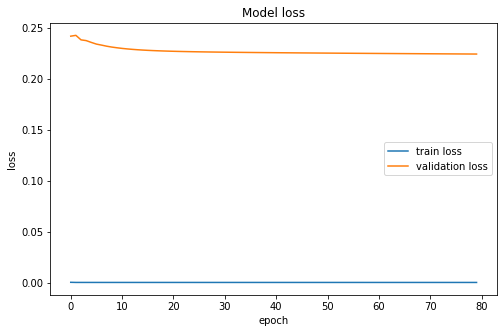

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#prediction
model5_yhat = model5.predict(valid3_X)

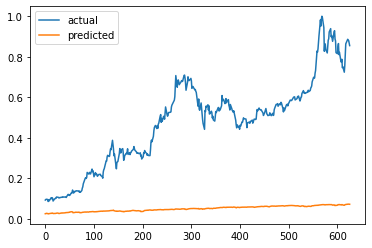

In [ ]:
plt.plot(valid3_y)
plt.plot(model5_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model5_rmse = sqrt(mean_squared_error(valid3_y, model5_yhat))
print('RMSE: {:.4f}'.format(model5_rmse))

model5_mae = mean_absolute_error(valid3_y, model5_yhat)
print('MAE: {:.4f}'.format(model5_mae))

RMSE: 0.4738
MAE: 0.4256


###### LSTM with more layers 

train/validation set for Feature set 3: `x_trai3`, `y_trai3`, `x_vali3`, `y_vali3`

In [ ]:
#prepare data 
batch_size = 100
buffer_size = 50
train3_data = tf.data.Dataset.from_tensor_slices((x_trai3, y_trai3))
train3_data = train3_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val3_data = tf.data.Dataset.from_tensor_slices((x_vali3, y_vali3))
val3_data = val3_data.batch(batch_size).repeat()

In [ ]:
#Build and compile the model

model6 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                              input_shape=x_trai3.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

model6.compile(optimizer='adam', loss='mse')

In [ ]:
history = model6.fit(train3_data, epochs=80, steps_per_epoch=10,
                         validation_data=val3_data, validation_steps=3,
                         verbose=1, shuffle=False
                         )

Epoch 1/80
10/10 [==============================] - 9s 214ms/step - loss: 1.2401e-04 - val_loss: 0.1353
Epoch 2/80
10/10 [==============================] - 0s 19ms/step - loss: 6.7496e-04 - val_loss: 0.1193
Epoch 3/80
10/10 [==============================] - 0s 17ms/step - loss: 5.3379e-04 - val_loss: 0.1224
Epoch 4/80
10/10 [==============================] - 0s 16ms/step - loss: 4.2602e-04 - val_loss: 0.1210
Epoch 5/80
10/10 [==============================] - 0s 18ms/step - loss: 4.6004e-04 - val_loss: 0.1239
Epoch 6/80
10/10 [==============================] - 0s 17ms/step - loss: 4.3474e-04 - val_loss: 0.1236
Epoch 7/80
10/10 [==============================] - 0s 17ms/step - loss: 8.8062e-05 - val_loss: 0.1247
Epoch 8/80
10/10 [==============================] - 0s 18ms/step - loss: 4.0481e-04 - val_loss: 0.1206
Epoch 9/80
10/10 [==============================] - 0s 18ms/step - loss: 4.3742e-04 - val_loss: 0.1207
Epoch 10/80
10/10 [==============================] - 0s 17ms/step - loss

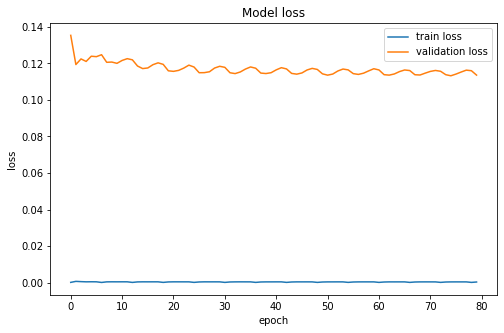

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#predictions
model6_yhat = model6.predict(x_vali3)

In [ ]:
#reshape for plot and rmse
y_vali3 = y_vali3.reshape(y_vali3.shape[0])
model6_yhat = model6_yhat.reshape(model6_yhat.shape[0])

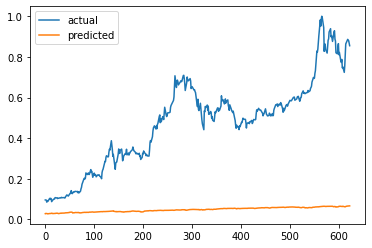

In [ ]:
plt.plot(y_vali3)
plt.plot(model6_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model6_rmse = sqrt(mean_squared_error(y_vali3, model6_yhat))
print('RMSE: {:.4f}'.format(model6_rmse))

model6_mae = mean_absolute_error(y_vali3, model6_yhat)
print('MAE: {:.4f}'.format(model6_mae))

RMSE: 0.4771
MAE: 0.4288


##### Model Comparison

In [ ]:
print("FEATURE SET 1")
print("-----------")
print("model1 RMSE: {:.4f}".format(model1_rmse))
print("model1 MAE: {:.4f}".format(model1_mae))
print("-----------")
print("model2 RMSE: {:.4f}".format(model2_rmse))
print("model2 MAE: {:.4f}".format(model2_mae))
print("-----------")
print("FEATURE SET 2")
print("-----------")
print("model3 RMSE: {:.4f}".format(model3_rmse))
print("model3 MAE: {:.4f}".format(model3_mae))
print("-----------")
print("model4 RMSE: {:.4f}".format(model4_rmse))
print("model4 MAE: {:.4f}".format(model4_mae))
print("-----------")
print("FEATURE SET 3")
print("-----------")
print("model5 RMSE: {:.4f}".format(model5_rmse))
print("model5 MAE: {:.4f}".format(model5_mae))
print("-----------")
print("model6 RMSE: {:.4f}".format(model6_rmse))
print("model6 MAE: {:.4f}".format(model6_mae))
print("-----------")


FEATURE SET 1
-----------
model1 RMSE: 0.4738
model1 MAE: 0.4254
-----------
model2 RMSE: 0.4780
model2 MAE: 0.4293
-----------
FEATURE SET 2
-----------
model3 RMSE: 0.0317
model3 MAE: 0.0220
-----------
model4 RMSE: 0.0325
model4 MAE: 0.0241
-----------
FEATURE SET 3
-----------
model5 RMSE: 0.4738
model5 MAE: 0.4256
-----------
model6 RMSE: 0.4771
model6 MAE: 0.4288
-----------


First, let's compare Feature set 1 and Feature set 3. Recall, Feature set 3 is a subset of Feature set 1, where Feature set 3 has only one Feature, `sp500`. 

The simple LSTM models, Model 1 and Model 5, have about the same error. However, when we compare the LSTM models with more layers, Model 2 and Model 6, Model 2 has the lower error metrics. Now that's an exciting story! So far, it appears that introducing information about Elon Musk's social influence increases the accuracy of our model to predict the stock price of Telsa. 

Next, let's look at Feature set 2. Recall that this feature set includes the full features at time `t-1` variables in addition to Tesla stock at `t-1`. This feature set is the best performing model, which makes sense given the features include data directly about tesla stock. Even though this appears like great news, I am curious whether what we are modeling is: "A good prediction for tomorrow's value is today's value." Exploring the theory of this feature creation technique would be an excellent opportunity for 
future research. 

#### LSTM with sliding window

Next, I will use a sliding window scheme with multi-step forecasting

##### Feature Set 1

In [ ]:
hist_window = 60    #sliding window length
horizon = 10        #how many days ahead to predict
TRAIN_SPLIT = 1260  #total obs to use

#train and validation set for LSTM with more layers
x_trai, y_trai = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print(x_trai.shape, y_trai.shape, x_vali.shape, y_vali.shape)

(1200, 60, 6) (1200, 10, 1) (496, 60, 6) (496, 10, 1)


In [ ]:
print("Percent Training Set: {:.1f}%".format(len(x_trai) / len(Y_data)*100))

Percent Training Set: 65.7%


In [ ]:
#prepare data 
batch_size = 100
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_trai, y_trai))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat() 

In [ ]:
#Build and compile the model

model7 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                              input_shape=x_trai.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

model7.compile(optimizer='adam', loss='mse')

In [ ]:
history = model7.fit(train_data, epochs=80, steps_per_epoch=10,
                         validation_data=val_data, validation_steps=3,
                         verbose=1, shuffle=False
                         )

Epoch 1/80
10/10 [==============================] - 17s 658ms/step - loss: 0.0038 - val_loss: 0.1773
Epoch 2/80
10/10 [==============================] - 4s 437ms/step - loss: 7.2768e-04 - val_loss: 0.1796
Epoch 3/80
10/10 [==============================] - 4s 432ms/step - loss: 0.0017 - val_loss: 0.1289
Epoch 4/80
10/10 [==============================] - 4s 443ms/step - loss: 0.0018 - val_loss: 0.1606
Epoch 5/80
10/10 [==============================] - 4s 432ms/step - loss: 0.0016 - val_loss: 0.1933
Epoch 6/80
10/10 [==============================] - 4s 427ms/step - loss: 8.3972e-04 - val_loss: 0.1785
Epoch 7/80
10/10 [==============================] - 4s 433ms/step - loss: 3.0212e-04 - val_loss: 0.1612
Epoch 8/80
10/10 [==============================] - 4s 441ms/step - loss: 8.1888e-04 - val_loss: 0.1327
Epoch 9/80
10/10 [==============================] - 4s 452ms/step - loss: 6.6852e-04 - val_loss: 0.1197
Epoch 10/80
10/10 [==============================] - 4s 445ms/step - loss: 5.82

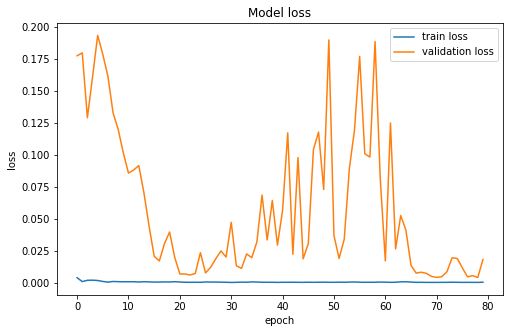

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#predictions
model7_yhat = model7.predict(x_vali)

In [ ]:
#reshape for plot and rmse
y_vali = y_vali[:,9,:]
y_vali.shape

(496, 1)

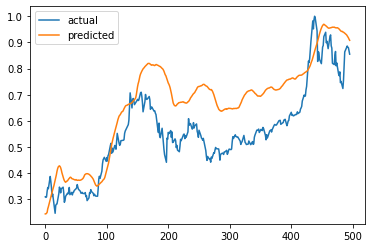

In [ ]:
plt.plot(y_vali)
plt.plot(model7_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model7_rmse = sqrt(mean_squared_error(y_vali, model7_yhat))
print('RMSE: {:.4f}'.format(model7_rmse))

model7_mae = mean_absolute_error(y_vali, model7_yhat)
print('MAE: {:.4f}'.format(model7_mae))

RMSE: 0.1370
MAE: 0.1208


##### Feature Set 2

In [ ]:
hist_window = 60
horizon = 10        #how many days ahead to predict
TRAIN_SPLIT = 1260  #total obs to use

#train and validation set for LSTM with more layers
x_trai2, y_trai2 = custom_ts_multi_data_prep(X_data2, Y_data2, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali2, y_vali2 = custom_ts_multi_data_prep(X_data2, Y_data2, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print(x_trai2.shape, y_trai2.shape, x_vali2.shape, y_vali2.shape)

(1200, 60, 6) (1200, 10) (495, 60, 6) (495, 10)


In [ ]:
print("Percent Training Set: {:.1f}%".format(len(x_trai2) / len(Y_data2)*100))

Percent Training Set: 65.8%


In [ ]:
#prepare data 
batch_size = 100
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_trai2, y_trai2))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali2, y_vali2))
val_data = val_data.batch(batch_size).repeat()

In [ ]:
#Build and compile the model

model8 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                              input_shape=x_trai2.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

model8.compile(optimizer='adam', loss='mse')

In [ ]:
history = model8.fit(train_data, epochs=80, steps_per_epoch=10,
                         validation_data=val_data, validation_steps=3,
                         verbose=1, shuffle=False
                         )

Epoch 1/80
10/10 [==============================] - 14s 622ms/step - loss: 0.0021 - val_loss: 0.2210
Epoch 2/80
10/10 [==============================] - 4s 428ms/step - loss: 0.0011 - val_loss: 0.2072
Epoch 3/80
10/10 [==============================] - 4s 449ms/step - loss: 0.0017 - val_loss: 0.1541
Epoch 4/80
10/10 [==============================] - 4s 441ms/step - loss: 0.0016 - val_loss: 0.1681
Epoch 5/80
10/10 [==============================] - 4s 419ms/step - loss: 0.0013 - val_loss: 0.1755
Epoch 6/80
10/10 [==============================] - 4s 428ms/step - loss: 8.0948e-04 - val_loss: 0.1635
Epoch 7/80
10/10 [==============================] - 4s 440ms/step - loss: 2.3299e-04 - val_loss: 0.1533
Epoch 8/80
10/10 [==============================] - 4s 452ms/step - loss: 8.3857e-04 - val_loss: 0.1300
Epoch 9/80
10/10 [==============================] - 4s 418ms/step - loss: 7.5112e-04 - val_loss: 0.1243
Epoch 10/80
10/10 [==============================] - 4s 447ms/step - loss: 6.4779e-

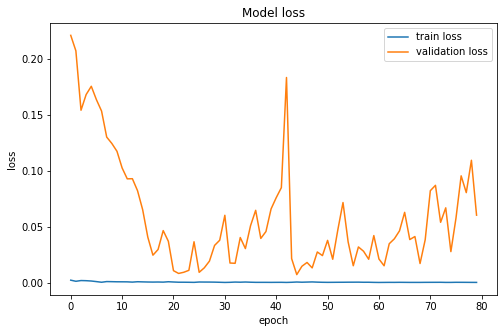

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#predictions
model8_yhat = model8.predict(x_vali2)

In [ ]:
#reshape for plot and rmse
y_vali2 = y_vali2[:,9]
y_vali2.shape

(495,)

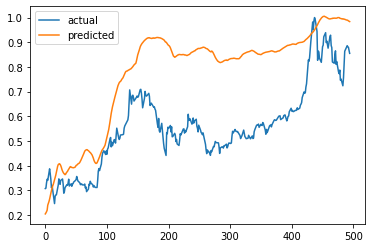

In [ ]:
plt.plot(y_vali2)
plt.plot(model8_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model8_rmse = sqrt(mean_squared_error(y_vali2, model8_yhat))
print('RMSE: {:.4f}'.format(model8_rmse))

model8_mae = mean_absolute_error(y_vali2, model8_yhat)
print('MAE: {:.4f}'.format(model8_mae))

RMSE: 0.2480
MAE: 0.2210


##### Feature Set 3

In [ ]:
hist_window = 60
horizon = 10        #how many days ahead to predict
TRAIN_SPLIT = 1260  #total obs to use

#train and validation set for LSTM with more layers
x_trai3, y_trai3 = custom_ts_multi_data_prep(X_data3, Y_data3, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali3, y_vali3 = custom_ts_multi_data_prep(X_data3, Y_data3, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print(x_trai3.shape, y_trai3.shape, x_vali3.shape, y_vali3.shape)

(1200, 60, 1) (1200, 10, 1) (496, 60, 1) (496, 10, 1)


In [ ]:
print("Percent Training Set: {:.1f}%".format(len(x_trai3) / len(Y_data3)*100))

Percent Training Set: 65.7%


In [ ]:
#prepare data 
batch_size = 100
buffer_size = 50
train_data = tf.data.Dataset.from_tensor_slices((x_trai3, y_trai3))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali3, y_vali3))
val_data = val_data.batch(batch_size).repeat()

In [ ]:
#Build and compile the model

model9 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                              input_shape=x_trai3.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

model9.compile(optimizer='adam', loss='mse')

In [ ]:
history = model9.fit(train_data, epochs=80, steps_per_epoch=10,
                         validation_data=val_data, validation_steps=3,
                         verbose=1, shuffle=False
                         )

Epoch 1/80
10/10 [==============================] - 16s 651ms/step - loss: 4.4604e-04 - val_loss: 0.2263
Epoch 2/80
10/10 [==============================] - 5s 455ms/step - loss: 0.0014 - val_loss: 0.2526
Epoch 3/80
10/10 [==============================] - 4s 440ms/step - loss: 0.0017 - val_loss: 0.1869
Epoch 4/80
10/10 [==============================] - 4s 434ms/step - loss: 0.0020 - val_loss: 0.1683
Epoch 5/80
10/10 [==============================] - 4s 440ms/step - loss: 0.0015 - val_loss: 0.1997
Epoch 6/80
10/10 [==============================] - 4s 430ms/step - loss: 9.2649e-04 - val_loss: 0.1981
Epoch 7/80
10/10 [==============================] - 4s 447ms/step - loss: 2.3186e-04 - val_loss: 0.2030
Epoch 8/80
10/10 [==============================] - 4s 432ms/step - loss: 8.5990e-04 - val_loss: 0.1905
Epoch 9/80
10/10 [==============================] - 4s 435ms/step - loss: 8.2749e-04 - val_loss: 0.1879
Epoch 10/80
10/10 [==============================] - 4s 433ms/step - loss: 8.54

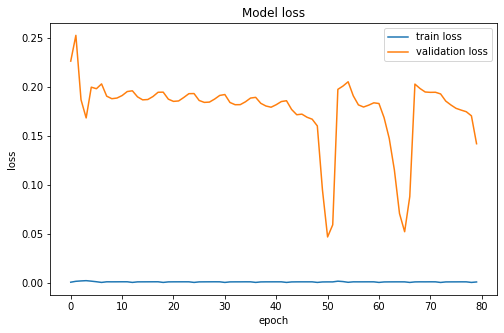

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#predictions
model9_yhat = model9.predict(x_vali3)

In [ ]:
#reshape for plot and rmse
y_vali3 = y_vali3[:,9,:]
y_vali3.shape

(496, 1)

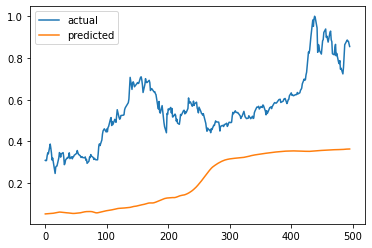

In [ ]:
plt.plot(y_vali3)
plt.plot(model9_yhat)
plt.legend(labels=['actual', 'predicted'])

In [ ]:
model9_rmse = sqrt(mean_squared_error(y_vali3, model9_yhat))
print('RMSE: {:.4f}'.format(model9_rmse))

model9_mae = mean_absolute_error(y_vali3, model9_yhat)
print('MAE: {:.4f}'.format(model9_mae))

RMSE: 0.3715
MAE: 0.3475


##### Model Comparison

In [ ]:
print("FEATURE SET 1")
print("-----------")
print("model7 RMSE: {:.4f}".format(model7_rmse))
print("model7 MAE: {:.4f}".format(model7_mae))
print("-----------")
print("FEATURE SET 2")
print("-----------")
print("model8 RMSE: {:.4f}".format(model8_rmse))
print("model8 MAE: {:.4f}".format(model8_mae))
print("-----------")
print("FEATURE SET 3")
print("-----------")
print("model9 RMSE: {:.4f}".format(model9_rmse))
print("model9 MAE: {:.4f}".format(model9_mae))
print("-----------")


FEATURE SET 1
-----------
model7 RMSE: 0.1370
model7 MAE: 0.1208
-----------
FEATURE SET 2
-----------
model8 RMSE: 0.2480
model8 MAE: 0.2210
-----------
FEATURE SET 3
-----------
model9 RMSE: 0.3715
model9 MAE: 0.3475
-----------


First, let's compare Feature set 1 and Feature set 3. Recall, Feature set 3 is a subset of Feature set 1, where Feature set 3 has only one Feature, `sp500`. 

Feature set 1 has lower error metrics than Feature set 3. Introducing more features about Elon Musk's social influence improves the accuracy of our models. I would love to explore different feature sets in the future to determine further which social features improve predictions the most.

Next, let's look at Feature set 2. Recall that this feature set includes the full features at time `t-1` variables in addition to Tesla stock at `t-1`. This feature set is the best performing model, which, again, makes sense given the features include data directly about tesla stock. Interestingly, introducing a sliding window scheme when training the LSTM gives us a smoother curve than not using the sliding window scheme (comparison of model 8 to model 3/4). This looks much less like "A good prediction for tomorrow's value is today's value," like we saw in model 3 and model 4 -- an excellent step forward!


## Facebook Prophet

A small fun exploration of Facebook Prophet with Univariate Time Series of TSLA stock

In [ ]:
#!pip install fbprophet
from fbprophet import Prophet

In [ ]:
#reformat df
df = elon_df
df['date'] = df.index
df = pd.concat([df['tsla'], df['date']], axis=1)
df = df.rename(columns={'date':'ds', 'tsla':'y'})

In [ ]:
df.head()

,y,ds
2017-01-01,43.398,2017-01-01
2017-01-02,43.398,2017-01-02
2017-01-03,43.398,2017-01-03
2017-01-04,45.398,2017-01-04
2017-01-05,45.350,2017-01-05


In [ ]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Python
future = m.make_future_dataframe(periods=100)
future.tail()

,ds
1921,2022-04-06
1922,2022-04-07
1923,2022-04-08
1924,2022-04-09
1925,2022-04-10


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1921,2022-04-06,1063.094880,987.682793,1137.579189
1922,2022-04-07,1063.646305,984.678661,1134.470356
1923,2022-04-08,1064.176193,983.123031,1144.734502
1924,2022-04-09,1065.516034,986.500337,1141.750878
1925,2022-04-10,1067.073023,992.612145,1145.313311


Text(0.5, 1.0, 'Prophet: TSLA Stock')

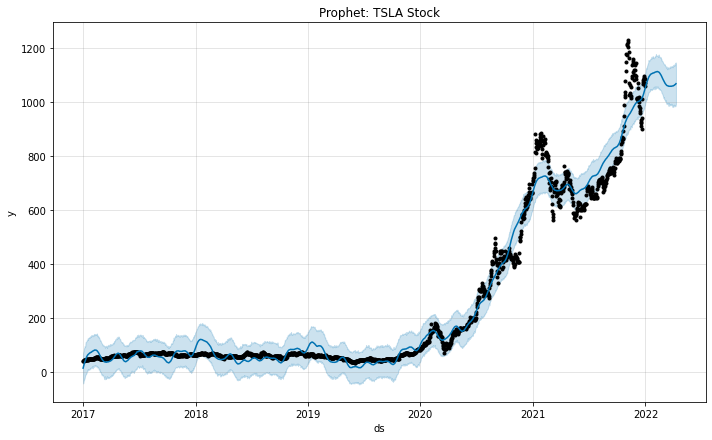

In [ ]:
fig1 = m.plot(forecast)
plt.title('Prophet: TSLA Stock')

# Take aways 

- Statistical model, VAR, based on time lags, is a low performing model for this problem. The best guess for tomorrow's value is today's value. We should be able to do better than this.

- With the LSTM framework, we determined that the full feature set (Feature set 1) performed better than only using the `sp500` (Feature set 3). Elon's social influence improves the prediction accuracy of our models (!). 

- Sliding window framework in LSTM modeling improves accuracy of our models


# Future Considerations

- Get More Data 
  - We only have 1826 days of data. I believe the LSTM models would excel given *much* more data
- Explore using Features with Differenced Data
  - We determined that `sp500` and `tsla` are not stationary series, but the first difference of these series pass the test for stationarity. Stationarity is not required for LSTM, but it would be interesting to see whether there was an improvement in modeling. 
- Explore more subsets of the full feature set
  - We determined that the full feature set (Feature set 1) performed better than only using the `sp500` (Feature set 3). I would like to determine further which social influence features increase the prediction accuracy of our models.
- Further explore theory used in Feature set 2
  - Our models with Feature set 2 (model 3, model 4, and model 8), utilized features at time `t-1` and Tesla and time `t-1`. I have curiosities about multicollinearity given that the Tesla information is in both the feature set and the target set.  
- Utilize more Twitter data
  - One fun part of this project was to get tweet information from the Twitter API. I would love to explore getting tweet sentiment as a feature.
- Up-to-Date Datasets
  - To fully utilize this analysis, I would like to have up-to-date information so we can make predictions in the moment, especially with the Twitter data. Using these models to make in-the-moment decisions for real-life implications would be great. 